# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('JointHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['JOINT']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-14 09:13:49,099|JointHoldingsAdjustement|INFO|Python version: 3.8.8
2022-11-14 09:13:49,101|JointHoldingsAdjustement|INFO|Pandas version: 1.2.4


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-14 09:13:49,118|JointHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-14 09:13:50,359|JointHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-13 00:00:00|2022-11-11 00:00:00
2022-11-14 09:13:50,387|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-14 09:13:50,441|JointHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-14 09:13:50,442|JointHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-14 09:13:50,702|JointHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-14 09:13:50,719|JointHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.015
2022-11-14 09:13:50,720|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.2
2022-11-14 09:13:50,721|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-14 09:17:14,575|JointHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.87|501->435


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-14 09:17:14,626|JointHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|435
2022-11-14 09:17:14,691|JointHoldingsAdjustement|INFO|OPT_DATE|2022-11-11 00:00:00


2022-11-14 09:17:28,168|JointHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01323470


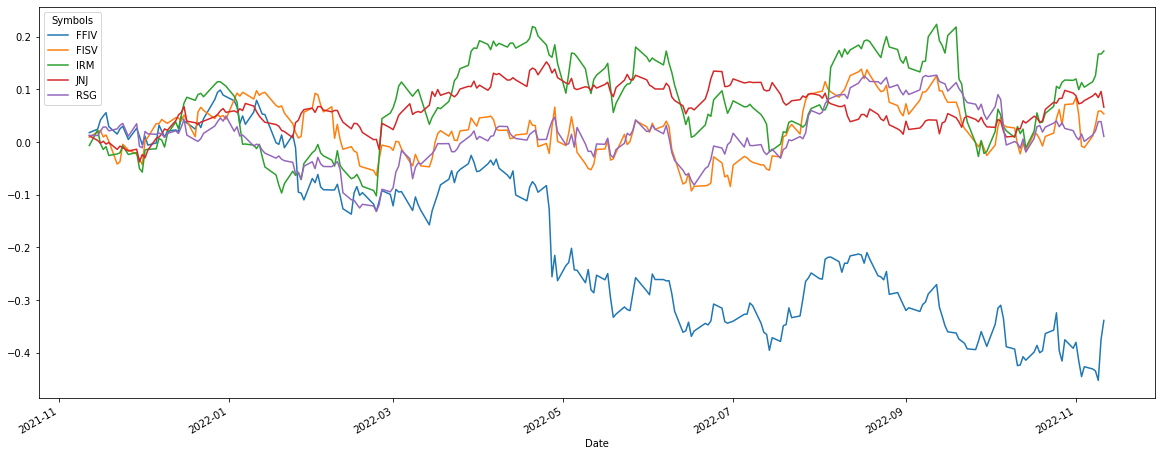

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-14 09:17:28,438|JointHoldingsAdjustement|INFO|STOCK|FFIV                |HOLDING|0.200000
2022-11-14 09:17:28,439|JointHoldingsAdjustement|INFO|STOCK|FISV                |HOLDING|0.200000
2022-11-14 09:17:28,440|JointHoldingsAdjustement|INFO|STOCK|IRM                 |HOLDING|0.200000
2022-11-14 09:17:28,441|JointHoldingsAdjustement|INFO|STOCK|JNJ                 |HOLDING|0.200000
2022-11-14 09:17:28,442|JointHoldingsAdjustement|INFO|STOCK|RSG                 |HOLDING|0.200000


In [9]:
import ameritrade_functions as amc
import utils

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

2022-11-14 09:17:28,557|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:17:28,559|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:17:28,587|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:17:28,588|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:17:28,679|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,NYSE,EQUITY,58.61,41.6700,2.474,4.68,2022-12-14 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.6185,2023-01-05 00:00:00.000,0.87396,1484760.0,1484757.0,34529950.0
1,337738108,FISV,"Fiserv, Inc. - Common Stock",NASDAQ,EQUITY,110.99,87.0300,0.000,0.00,,...,51.86217,0.0,0.0,0.0,0.0000,,0.87926,5247570.0,5247571.0,89812410.0
2,478160104,JNJ,Johnson & Johnson Common Stock,NYSE,EQUITY,186.69,155.7200,4.520,2.67,2022-11-21 00:00:00.000,...,1.59249,0.0,0.0,0.0,1.1300,2022-12-06 00:00:00.000,0.56364,6866600.0,6866603.0,152987270.0
3,760759100,RSG,"Republic Services, Inc. Common Stock",NYSE,EQUITY,149.17,113.5734,1.980,1.51,2022-12-30 00:00:00.000,...,4.54913,0.0,0.0,0.0,0.4950,2023-01-13 00:00:00.000,0.66600,1515330.0,1515329.0,25110730.0
4,315616102,FFIV,"F5, Inc. - Common Stock",NASDAQ,EQUITY,249.00,133.6750,0.000,0.00,,...,15.99641,0.0,0.0,0.0,0.0000,,1.08697,561440.0,561442.0,11037650.0


Tickers:   0%|          | 0/5 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/5 [00:00<?, ?News Table Items/s]

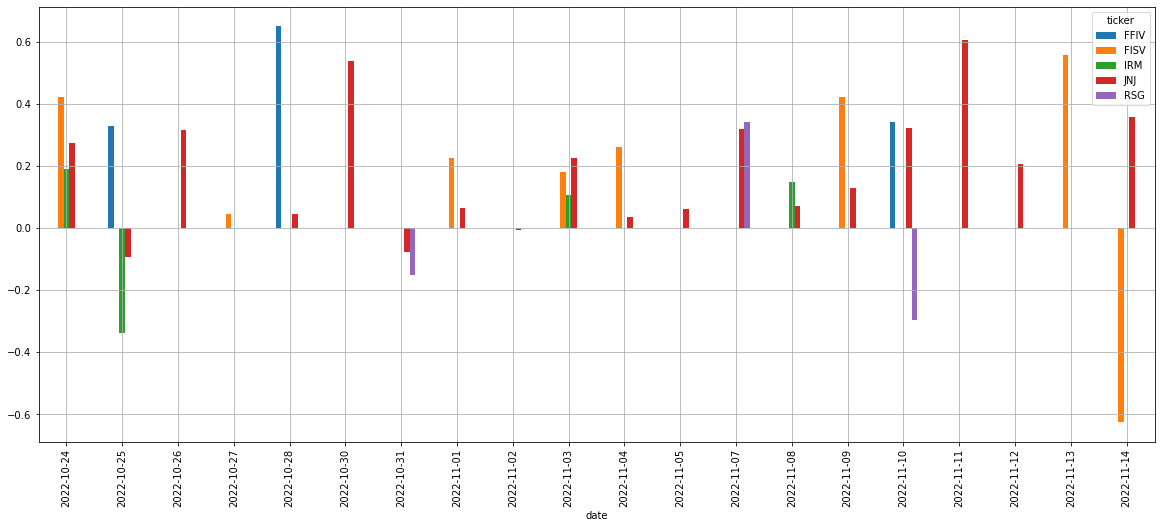

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error('Error: No authorization data: {}'.format(td_ameritrade.authorization))
    raise SystemExit
else:
    logger.info('You have authorization')

2022-11-14 09:18:15,054|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:18:15,057|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:18:15,093|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:18:15,095|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:18:15,160|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-14 09:18:21,919|JointHoldingsAdjustement|INFO|You have authorization


In [12]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-14 09:18:21,931|JointHoldingsAdjustement|INFO|TRADE_DATE|2022-11-14 09:18:21.931418
2022-11-14 09:18:24,217|JointHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 O                 0.0      62.99500             0.0   
         WKHS              0.0      10.49180             0.0   
         EEENF             0.0       0.04980             0.0   
         EA                0.0     130.83737             0.0   
         FGPHF             0.0       0.10927             0.0   
         IVZ               0.0      15.73500             0.0   
         K                 0.0      70.33000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 O                      -1.20                           -0.05   
         WKHS                   -3.00                           -0.36   
         EEENF                   0.00                            0.00   
         EA                     -4.37                           -0.18   
         FGPHF                   0.00                            0.00   
         IVZ                     0.00                            0.00   
         K                       1.52                            0.12   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 O               40.0                 40.0                   0.0   
         WKHS           300.0                300.0                   0.0   
         EEENF          250.0                250.0                   0.0   
         EA              19.0                 19.0                   0.0   
         FGPHF        25000.0              25000.0                   0.0   
         IVZ            160.0                160.0                   0.0   
         K               19.0                 19.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 O           2598.00                  779.40   
         WKHS         840.00                  600.00   
         EEENF          1.63                    0.00   
         EA          2489.00                  746.70   
         FGPHF       2368.50                    0.00   
         IVZ         3163.20                  948.96   
         K           1312.14                  393.64   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 O                              40.0    EQUITY  756109104           0   
         WKHS                          300.0    EQUITY  98138J206           0   
         EEENF                         250.0    EQUITY  Q3394D101           0   
         EA                             19.0    EQUITY  285512109           0   
         FGPHF                       25000.0    EQUITY  Q3860H107           0   
         IVZ                           160.0    EQUITY  G491BT108           0   
         K                              19.0    EQUITY  487836108           0   

                type  
account  symbol       
#---2021 O         0  
         WKHS      0  
         EEENF     0  
         EA        0  
         FGPHF     0  
         IVZ       0  
         K         0

In [13]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-11-14 09:18:24,525|JointHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 O                 0.0      62.99500             0.0   
         EA                0.0     130.83737             0.0   
         IVZ               0.0      15.73500             0.0   
         K                 0.0      70.33000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 O                      -1.20                           -0.05   
         EA                     -4.37                           -0.18   
         IVZ                     0.00                            0.00   
         K                       1.52                            0.12   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 O               40.0                 40.0                   0.0   
         EA              19.0                 19.0                   0.0   
         IVZ            160.0                160.0                   0.0   
         K               19.0                 19.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 O           2598.00                  779.40   
         EA          2489.00                  746.70   
         IVZ         3163.20                  948.96   
         K           1312.14                  393.64   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 O                              40.0    EQUITY  756109104           0   
         EA                             19.0    EQUITY  285512109           0   
         IVZ                           160.0    EQUITY  G491BT108           0   
         K                              19.0    EQUITY  487836108           0   

                type  
account  symbol       
#---2021 O         0  
         EA        0  
         IVZ       0  
         K         0

### Submit and montior sell orders

In [14]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

2022-11-14 09:18:24,580|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:18:24,586|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:18:24,656|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:18:24,658|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:18:24,725|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing SELL order on #---2021 for 40.0 shares of O...
Placed SELL order on #---2021 for 40.0 shares of O
Placing SELL order on #---2021 for 19.0 shares of EA...
Placed SELL order on #---2021 for 19.0 shares of EA
Placing SELL order on #---2021 for 160.0 shares of IVZ...
Placed SELL order on #---2021 for 160.0 shares of IVZ
Placing SELL order on #---2021 for 19.0 shares of K...
Placed SELL order on #---2021 for 19.0 shares of K


In [15]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


2022-11-07 10:12:45,776|WDM|INFO|



====== WebDriver manager ======


2022-11-07 10:12:45,779|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-07 10:12:45,824|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-07 10:12:45,829|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-07 10:12:45,929|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
All stocks sold|['APA' 'PFE' 'CTSH' 'ES' 'FAST']|INFO|


In [15]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

2022-11-14 09:50:35,794|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:50:35,797|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:50:35,844|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:50:35,846|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:50:35,929|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             11396.610000
initialBalances_moneyMarketFund      987.220000
currentBalances_cashBalance         9531.250000
currentBalances_equity             11310.470000
currentBalances_moneyMarketFund      987.220000
current_return                        -0.007587
Name: #---2021, dtype: float64

9531.25
987.22
2022-11-14 09:51:15,266|JointHoldingsAdjustement|INFO|INVESTMENT_AMT|10518.47


In [16]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 10518.47
Amount to invest: 10000


In [17]:
long_weights

,optimalWeights
FFIV,0.2
FISV,0.2
IRM,0.2
JNJ,0.2
RSG,0.2


In [18]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-14 09:53:23.725556
Initial investment amount: 10000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
FFIV,150.2000,0.2,2000.0,13
FISV,100.4200,0.2,2000.0,19
IRM,52.4982,0.2,2000.0,38
JNJ,170.9200,0.2,2000.0,11
RSG,131.5400,0.2,2000.0,15


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
FFIV,150.2000,0.2,2000.0,13,1952.6000
FISV,100.4200,0.2,2000.0,19,1907.9800
IRM,52.4982,0.2,2000.0,38,1994.9316
JNJ,170.9200,0.2,2000.0,11,1880.1200
RSG,131.5400,0.2,2000.0,15,1973.1000


Total cost: 9708.7316


### Place buy orders

In [19]:
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,NYSE,EQUITY,58.61,41.6700,2.474,4.68,2022-12-14 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.6185,2023-01-05 00:00:00.000,0.87396,1484760.0,1484757.0,34529950.0
1,337738108,FISV,"Fiserv, Inc. - Common Stock",NASDAQ,EQUITY,110.99,87.0300,0.000,0.00,,...,51.86217,0.0,0.0,0.0,0.0000,,0.87926,5247570.0,5247571.0,89812410.0
2,478160104,JNJ,Johnson & Johnson Common Stock,NYSE,EQUITY,186.69,155.7200,4.520,2.67,2022-11-21 00:00:00.000,...,1.59249,0.0,0.0,0.0,1.1300,2022-12-06 00:00:00.000,0.56364,6866600.0,6866603.0,152987270.0
3,760759100,RSG,"Republic Services, Inc. Common Stock",NYSE,EQUITY,149.17,113.5734,1.980,1.51,2022-12-30 00:00:00.000,...,4.54913,0.0,0.0,0.0,0.4950,2023-01-13 00:00:00.000,0.66600,1515330.0,1515329.0,25110730.0
4,315616102,FFIV,"F5, Inc. - Common Stock",NASDAQ,EQUITY,249.00,133.6750,0.000,0.00,,...,15.99641,0.0,0.0,0.0,0.0000,,1.08697,561440.0,561442.0,11037650.0


In [20]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-14 09:53:31.184341
2022-11-14 09:53:31,185|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:53:31,187|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:53:31,231|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:53:31,233|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:53:31,337|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing BUY order on 768492021 for 13.0 shares of FFIV:EQUITY...
Placed BUY order on #---2021 for 13.0 shares of FFIV
Placing BUY order on 768492021 for 19.0 shares of FISV:EQUITY...
Placed BUY order on #---2021 for 19.0 shares of FISV
Placing BUY order on 768492021 for 38.0 shares of IRM:EQUITY...
Placed BUY order on #---2021 for 38.0 shares of IRM
Placing BUY order on 768492021 for 11.0 shares of JNJ:EQUITY...
Placed BUY order on #---2021 for 11.0 shares of JNJ
Placing BUY order on 768492021 for 15.0 shares of RSG:EQUITY...
Placed BUY order on #---2021 for 15.0 shares of RSG


Tickers:   0%|          | 0/5 [00:00<?, ?Price Histories/s]

<AxesSubplot:xlabel='date'>

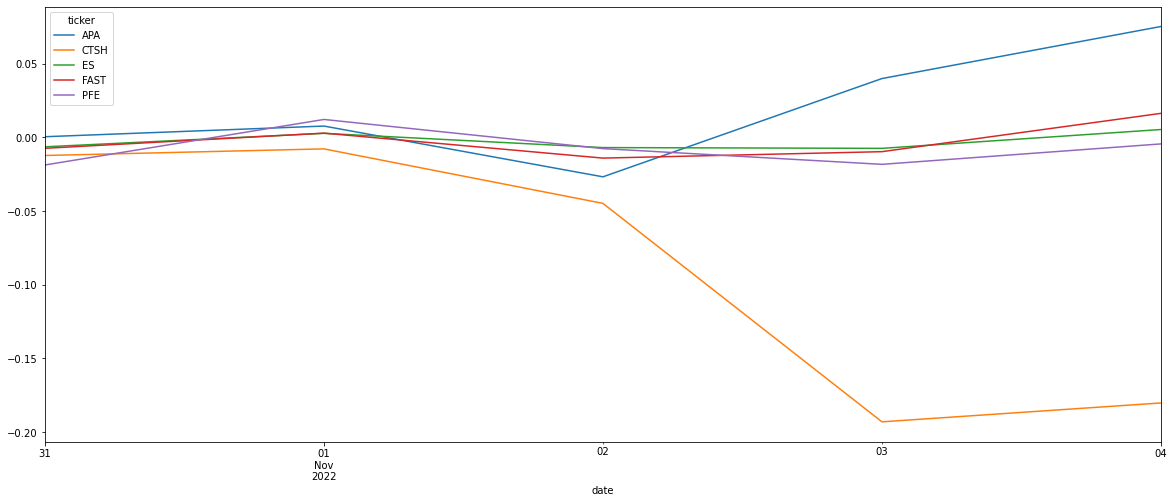

In [23]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]